## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy
from scipy.optimize import minimize
#import qiskit

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(42)

In [3]:
def ansatz_custom(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [4]:
#def ansatz_inverse(params, n_wires_latent, n_wires_trash):
#    params = params[::-1]
#    for j in reversed(range(5)):
#        if j != 4:
#            for i in reversed(range(n_wires_latent + n_wires_trash - 1)):
#                qml.CNOT(wires=[i, i+1])
#        for i in reversed(range(n_wires_latent + n_wires_trash)):
#            k = j*5+i
#            qml.RY(-params[k], wires=i)


In [3]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [4]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [5]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [8]:
def quantum_encoder_train(params, n_wires_latent, n_wires_trash):
    ansatz_custom(params,n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)

In [9]:
@qml.qnode(dev)
def domain_wall(params):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(params, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [10]:
params = np.random.random((30,))
params = qml.numpy.tensor(params, requires_grad=True)

(<Figure size 2400x900 with 1 Axes>, <Axes: >)


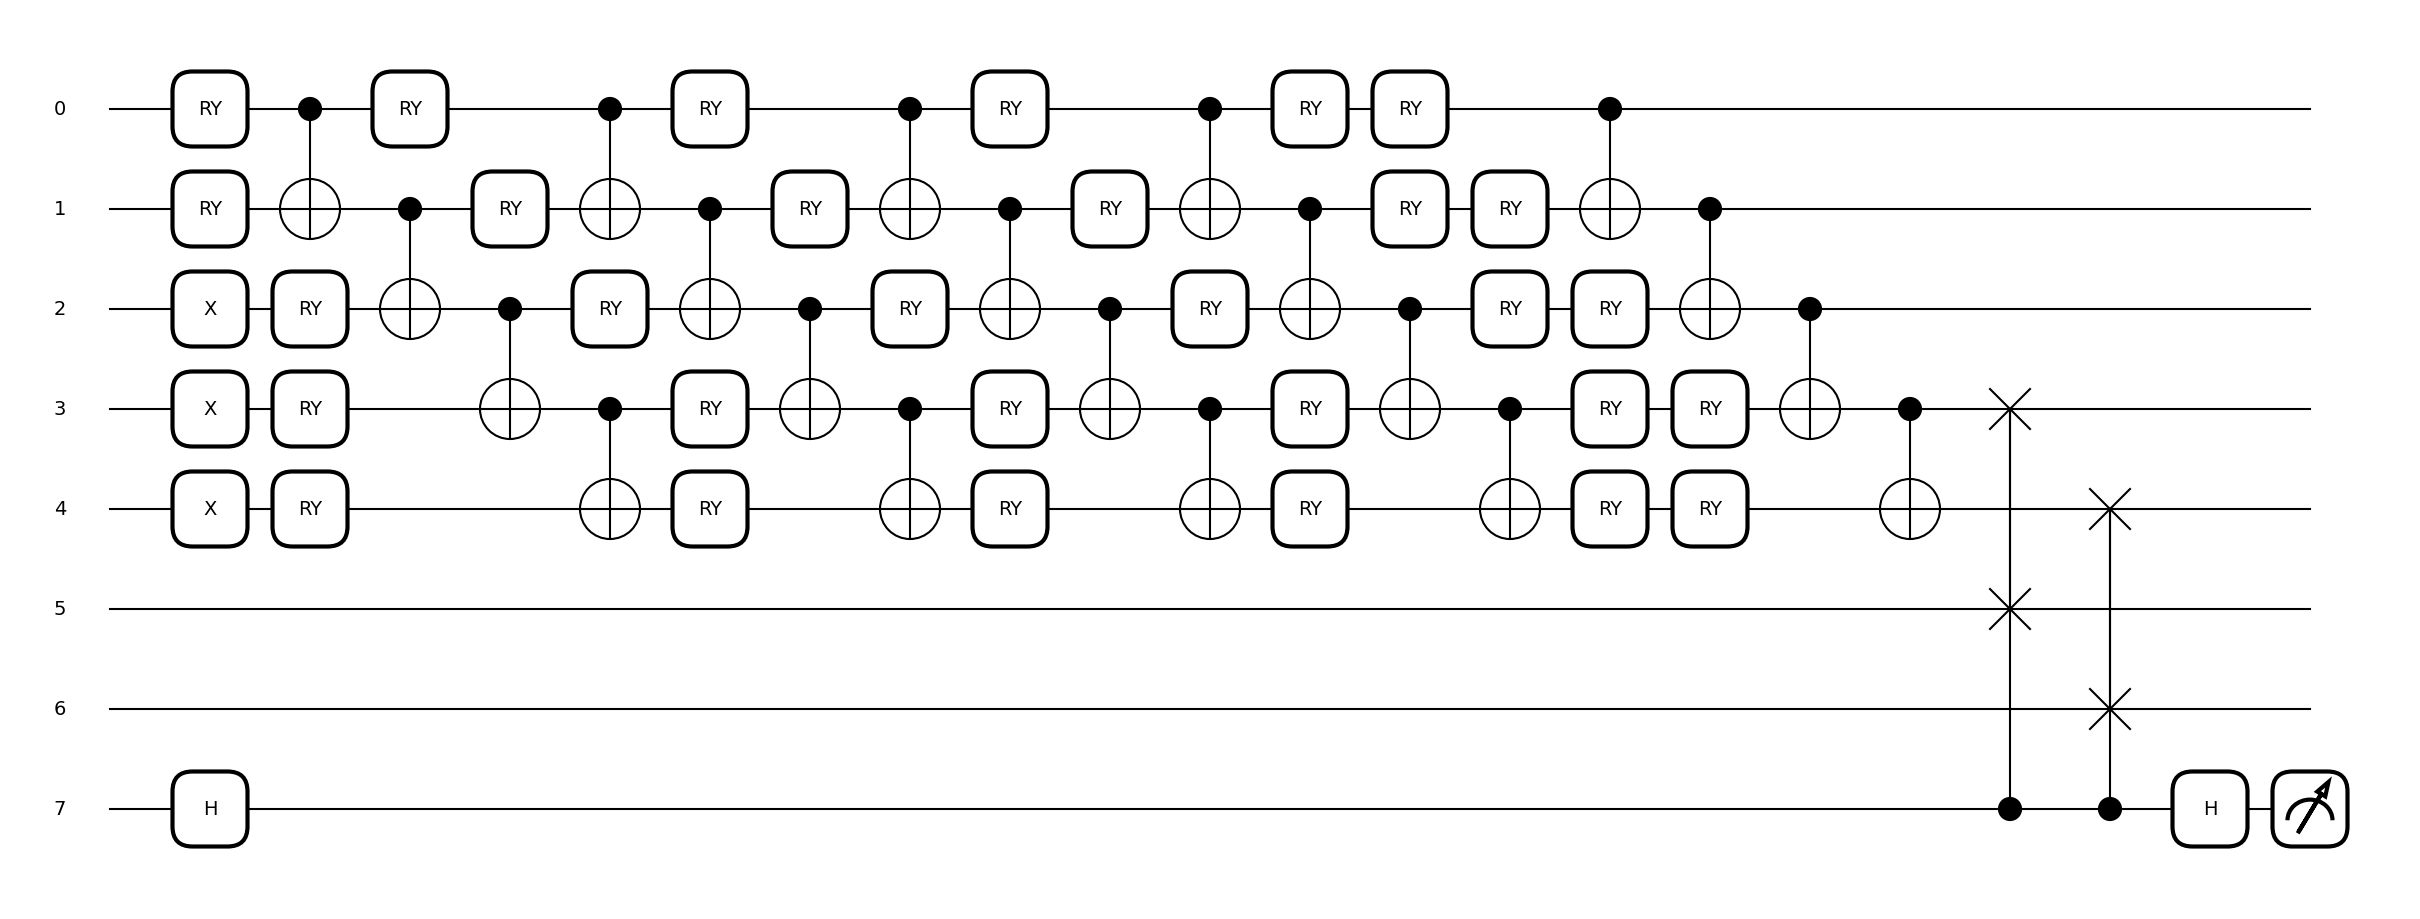

In [11]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [12]:
def cost_function(params):
    probs = domain_wall(params)
    cost = np.sum(probs[1])
    return cost

In [13]:
#opt = qml.GradientDescentOptimizer(stepsize=0.1)
#steps = 150
#costs = []

# Learning
#start = time.time()
#for i in range(steps):
#    params, cost_val = opt.step_and_cost(cost_function, params)
#    costs.append(cost_val)

#elapsed = time.time() - start
#print(f"Fit in {elapsed:0.2f} seconds")


In [14]:
cost_values = []
opt_weights = []
def callback(xk):
    cost_val = cost_function(xk)
    cost_values.append(cost_val)
    opt_weights.append(xk)
    print(f"Step {len(cost_values)}: cost = {cost_val:.4f}, params = {xk}")

In [15]:
minimize(cost_function, params, method='COBYLA', callback=callback, options={'maxiter': 250})
opt_weights = opt_weights[-1]

Step 1: cost = 0.3396, params = [1.18343479e+00 7.79691000e-01 5.96850158e-01 4.45832753e-01
 9.99749158e-02 4.59248892e-01 3.33708611e-01 1.42866818e-01
 6.50888473e-01 5.64115790e-02 7.21998772e-01 9.38552709e-01
 7.78765841e-04 9.92211559e-01 6.17481510e-01 6.11653160e-01
 7.06630522e-03 2.30624250e-02 5.24774660e-01 3.99860972e-01
 4.66656632e-02 9.73755519e-01 2.32771340e-01 9.06064345e-02
 6.18386009e-01 3.82461991e-01 9.83230886e-01 4.66762893e-01
 8.59940407e-01 6.80307539e-01]
Step 2: cost = 0.3546, params = [1.18343479e+00 1.77969100e+00 5.96850158e-01 4.45832753e-01
 9.99749158e-02 4.59248892e-01 3.33708611e-01 1.42866818e-01
 6.50888473e-01 5.64115790e-02 7.21998772e-01 9.38552709e-01
 7.78765841e-04 9.92211559e-01 6.17481510e-01 6.11653160e-01
 7.06630522e-03 2.30624250e-02 5.24774660e-01 3.99860972e-01
 4.66656632e-02 9.73755519e-01 2.32771340e-01 9.06064345e-02
 6.18386009e-01 3.82461991e-01 9.83230886e-01 4.66762893e-01
 8.59940407e-01 6.80307539e-01]
Step 3: cost = 0.3

In [16]:
#opt_weights = params
print(opt_weights)

[ 1.21755742  1.25097395  1.94255792 -0.0356018   1.52224875  0.27513883
  1.4839875  -0.28380704  0.78236174  0.02616098  1.63358219  1.25108022
  1.12947587  2.37843991  0.08318686  2.019175    0.34366353 -0.26131619
  0.99369585  0.05476964 -0.35617199  0.78909848 -0.16521829  0.04221878
  0.84110738  0.15202405  0.81907286  0.52434278  0.77328109  0.68875473]


In [17]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights])


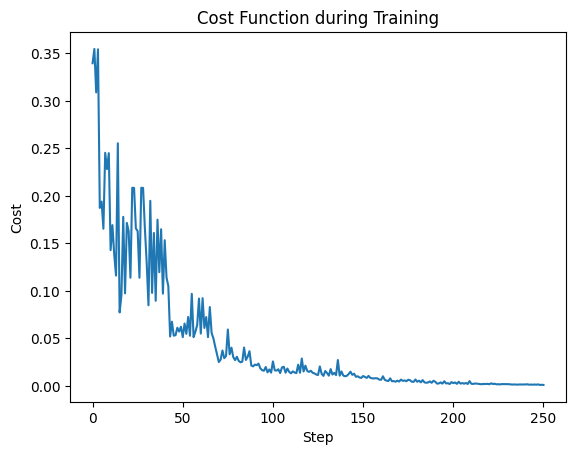

In [18]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [19]:
print(cost_values[-1])

0.0009328496930756407


In [20]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [21]:
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [22]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz_custom(opt_weights, n_wires_latent, n_wires_trash) 
    #domain_wall(opt_weights)
    wir=[3, 4]
    reset_to_zero(wir)
    #opt_weights_inv = -opt_weights
    qml.adjoint(ansatz_custom)(opt_weights, n_wires_latent, n_wires_trash)
    #ansatz_inverse(opt_weights, n_wires_latent, n_wires_trash)
    #print(p)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]


In [23]:
autoencoder(opt_weights)

[tensor(0.99623261, requires_grad=True),
 tensor(0.99585034, requires_grad=True),
 tensor(-0.99628433, requires_grad=True),
 tensor(-0.99544894, requires_grad=True),
 tensor(-0.99818127, requires_grad=True)]

(<Figure size 4300x700 with 1 Axes>, <Axes: >)


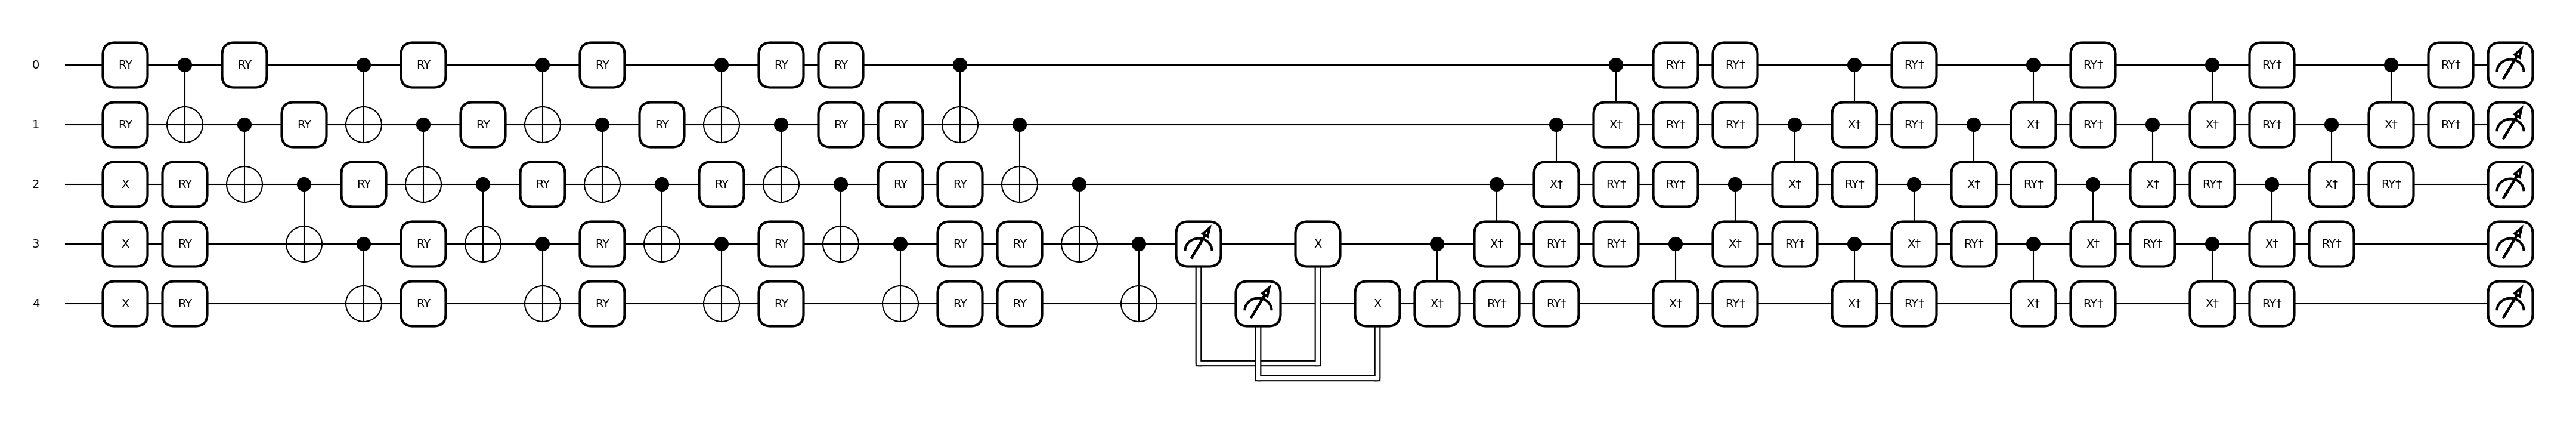

In [24]:
drawer_1 = qml.draw_mpl(autoencoder)
print(drawer_1(opt_weights))

# DIFFERENT WAY #

In [25]:
dev_autoencoder5 = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash+2)
@qml.qnode(dev_autoencoder5)
def autoencoder_state(opt_weights):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz_custom(opt_weights, n_wires_latent, n_wires_trash) 
    qml.SWAP(wires=[3, 6])
    qml.SWAP(wires=[4, 5])
    #opt_weights_inv = -opt_weights
    qml.adjoint(ansatz_custom)(opt_weights, n_wires_latent, n_wires_trash)
    #ansatz_inverse(opt_weights, n_wires_latent, n_wires_trash) 
    return qml.density_matrix([0,1,2,3,4])

(<Figure size 4100x800 with 1 Axes>, <Axes: >)


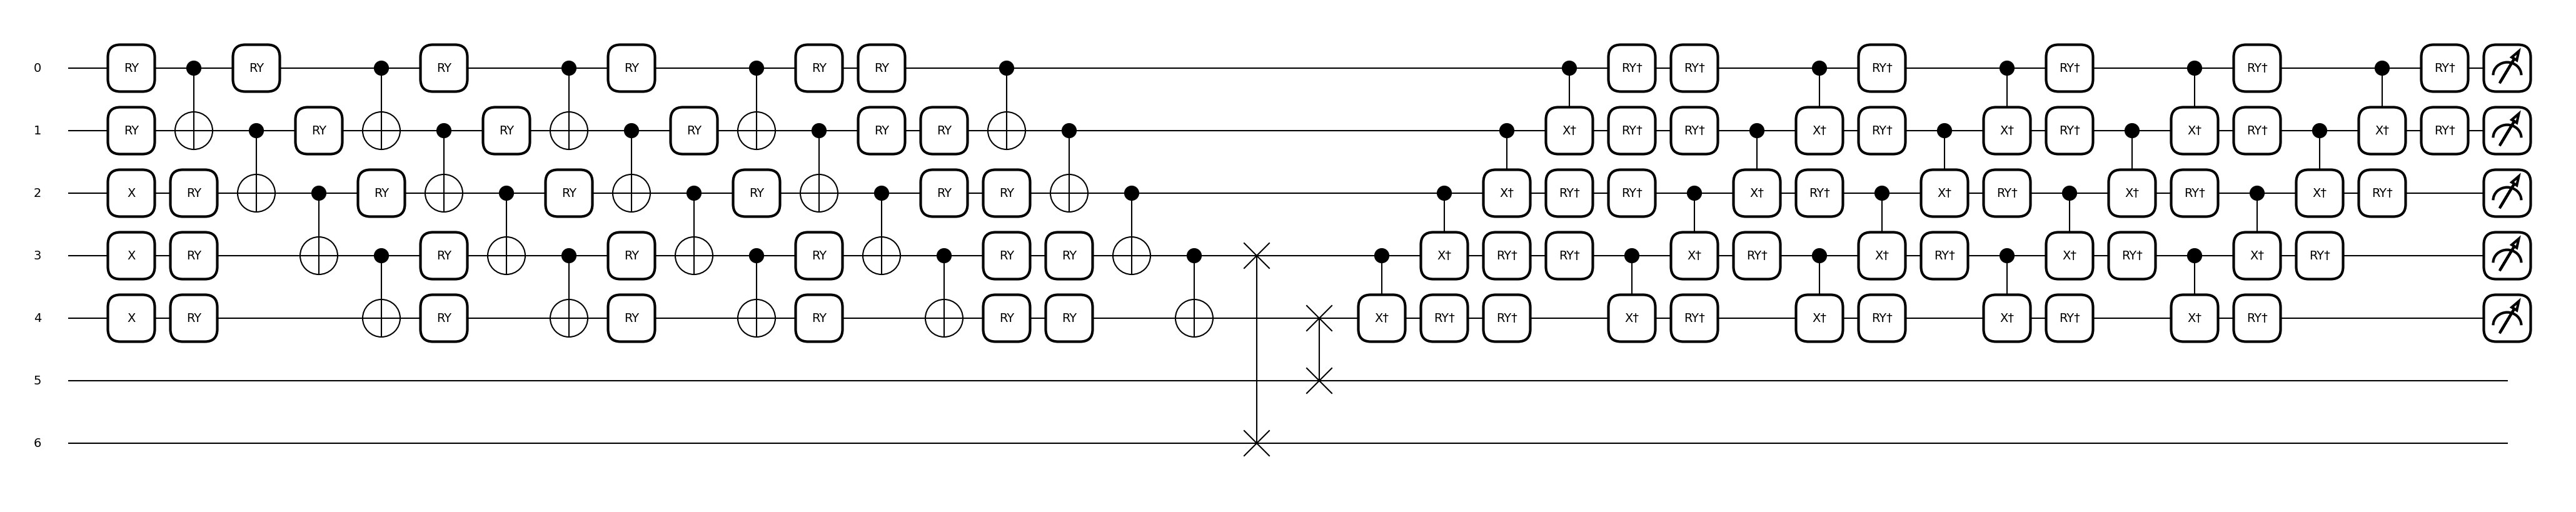

In [26]:
drawer_6 = qml.draw_mpl(autoencoder_state)
print(drawer_6(opt_weights))

In [27]:
dev_initial = qml.device("default.qubit", wires=5)
@qml.qnode(dev_initial)
def initial_state_dom():
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    qml.X(2)
    qml.X(3)
    qml.X(4)
    return qml.density_matrix([0,1,2,3,4])

(<Figure size 400x600 with 1 Axes>, <Axes: >)


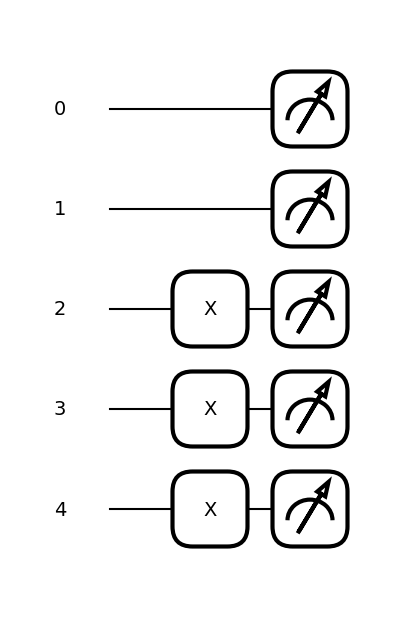

In [28]:
drawer_6 = qml.draw_mpl(initial_state_dom)
print(drawer_6())

In [29]:
print(qml.math.fidelity(initial_state_dom(), autoencoder_state(opt_weights)))

0.996279767526788


# DIGIT DATASET #

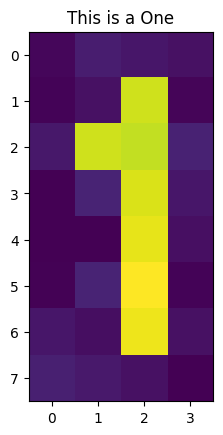

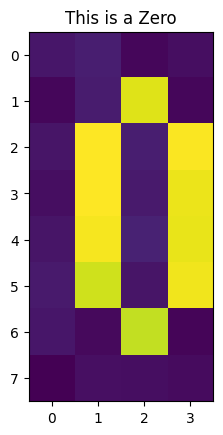

In [6]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)


        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = np.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([np.random.uniform(0, 0.1) for i in range(32)]).reshape(8, 4)

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = np.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, train_labes = get_dataset_digits(2)

In [7]:
image= train_images[0]
print(image)

[7.29998792e-03 3.10286554e-02 2.37523043e-02 1.77424016e-02
 3.97861103e-03 1.82763115e-02 3.67353507e-01 5.68554115e-03
 2.59028181e-02 3.67756707e-01 3.58800230e-01 3.73507307e-02
 3.09918377e-05 3.94861433e-02 3.73502906e-01 2.43414059e-02
 2.81211338e-04 9.17794407e-04 3.80581505e-01 1.59129043e-02
 1.85711106e-03 3.87516650e-02 3.95660784e-01 3.60578208e-03
 2.46093470e-02 1.52204929e-02 3.85356054e-01 1.85753394e-02
 3.42222682e-02 2.70735819e-02 1.79281100e-02 5.27893625e-04]


In [8]:
def ansatz_custom_digits(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [9]:
@qml.qnode(dev)
def train_circuit(params, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [10]:
params_digits = np.random.random((30,))
params_digits = qml.numpy.tensor(params_digits, requires_grad=True)

(<Figure size 4000x900 with 1 Axes>, <Axes: >)


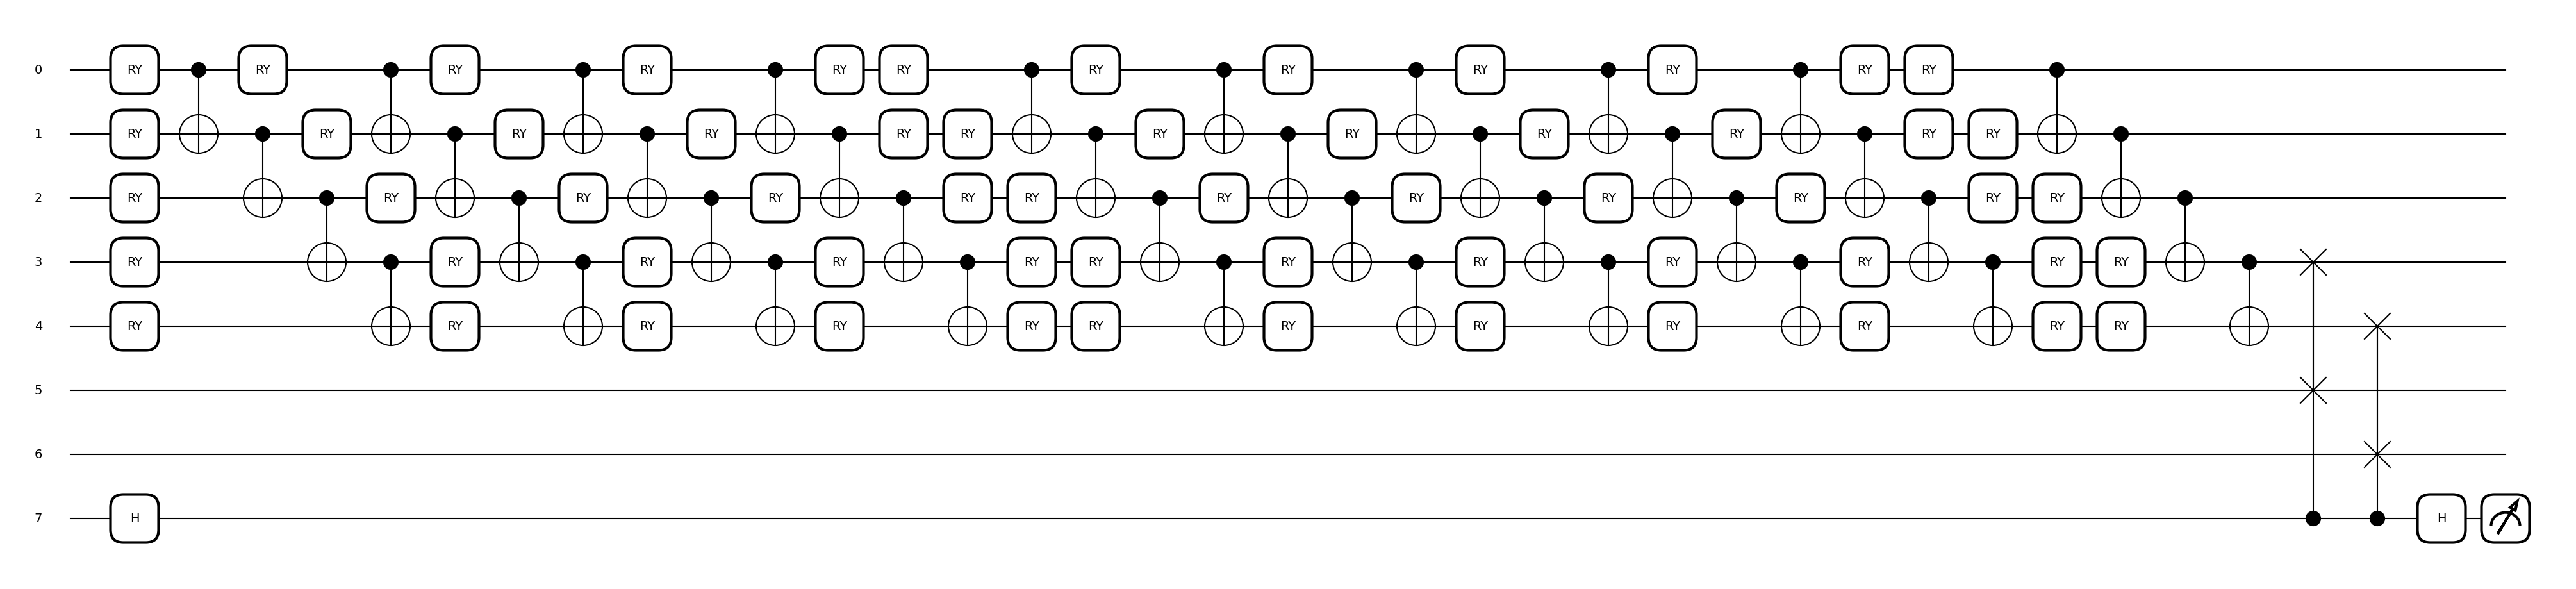

In [11]:
drawer_2 = qml.draw_mpl(train_circuit)
print(drawer_2(params_digits, image))

In [ ]:
def cost_function_digits(params, image):
    probs = train_circuit(params, image)
    cost = np.sum(probs[1])
    return cost

In [12]:
def cost_function_digits(weights):
    probabilities = [train_circuit(weights, image) for image in train_images]
    cost_value = np.sum([p[1] for p in probabilities])
    return cost_value

In [13]:
cost_values_digits = []
opt_weights_digits = []
def callback(xk):
    cost_val = cost_function_digits(xk)
    cost_values_digits.append(cost_val)
    opt_weights_digits.append(xk)
    print(f"Step {len(cost_values_digits)}: cost = {cost_val:.4f}, params = {xk}")

In [14]:
minimize(cost_function_digits, params_digits, method='COBYLA', callback=callback, options={'maxiter': 500})
opt_weights_digits = opt_weights_digits[-1]

Step 1: cost = 0.7772, params = [1.09541012 0.37081825 0.66884125 0.66592236 0.59129779 0.27472179
 0.56124343 0.38292687 0.9717121  0.84891382 0.72172952 0.23598492
 0.25606832 0.04043359 0.71066289 0.11089082 0.4393365  0.2017192
 0.8957636  0.47537022 0.56327557 0.69551609 0.13933145 0.60441738
 0.53984109 0.20306122 0.94285357 0.59886547 0.69478493 0.88046784]
Step 2: cost = 0.8219, params = [1.09541012 1.37081825 0.66884125 0.66592236 0.59129779 0.27472179
 0.56124343 0.38292687 0.9717121  0.84891382 0.72172952 0.23598492
 0.25606832 0.04043359 0.71066289 0.11089082 0.4393365  0.2017192
 0.8957636  0.47537022 0.56327557 0.69551609 0.13933145 0.60441738
 0.53984109 0.20306122 0.94285357 0.59886547 0.69478493 0.88046784]
Step 3: cost = 0.8042, params = [1.09541012 0.37081825 1.66884125 0.66592236 0.59129779 0.27472179
 0.56124343 0.38292687 0.9717121  0.84891382 0.72172952 0.23598492
 0.25606832 0.04043359 0.71066289 0.11089082 0.4393365  0.2017192
 0.8957636  0.47537022 0.56327557 

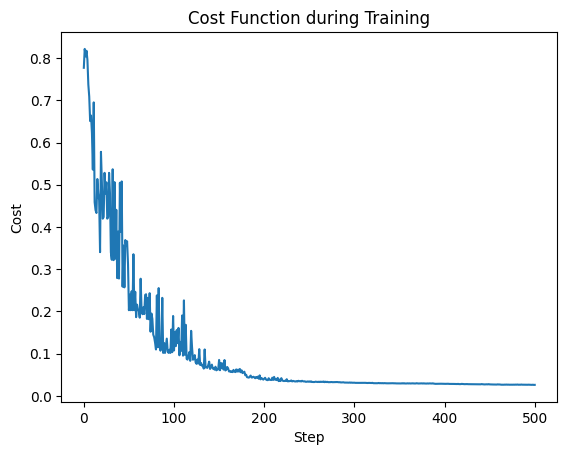

In [16]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values_digits)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [31]:
initial_point_digits = np.random.random((5,))
initial_point = np.random.random((5,))
#print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
initial_point_digits = qml.numpy.tensor(initial_point_digits, requires_grad=True)

weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
weights_digits = np.random.random((2, 4, 2))
weights_digits = qml.numpy.tensor(weights_digits, requires_grad=True)
#print(np.shape(weights))
#print(weights)
params_digits = np.concatenate([initial_point, initial_point_digits, weights.flatten(), weights_digits.flatten()])
params_digits = qml.numpy.tensor(params_digits, requires_grad=True)
#print(params)
#print(params[:5])

In [32]:
def ansatz_enc(params, n_wires_latent, n_wires_trash):
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[26:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [33]:
def ansatz_digits(params, n_wires_latent, n_wires_trash):
    init_weights = params[5:10]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[10:26]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [34]:
dev = qml.device("default.qubit", wires=n_wires_total)
@qml.qnode(dev)
def digits_autoencoder(params):
    ansatz_enc(params, n_wires_latent, n_wires_trash)
    ansatz_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)


(<Figure size 800x900 with 1 Axes>, <Axes: >)


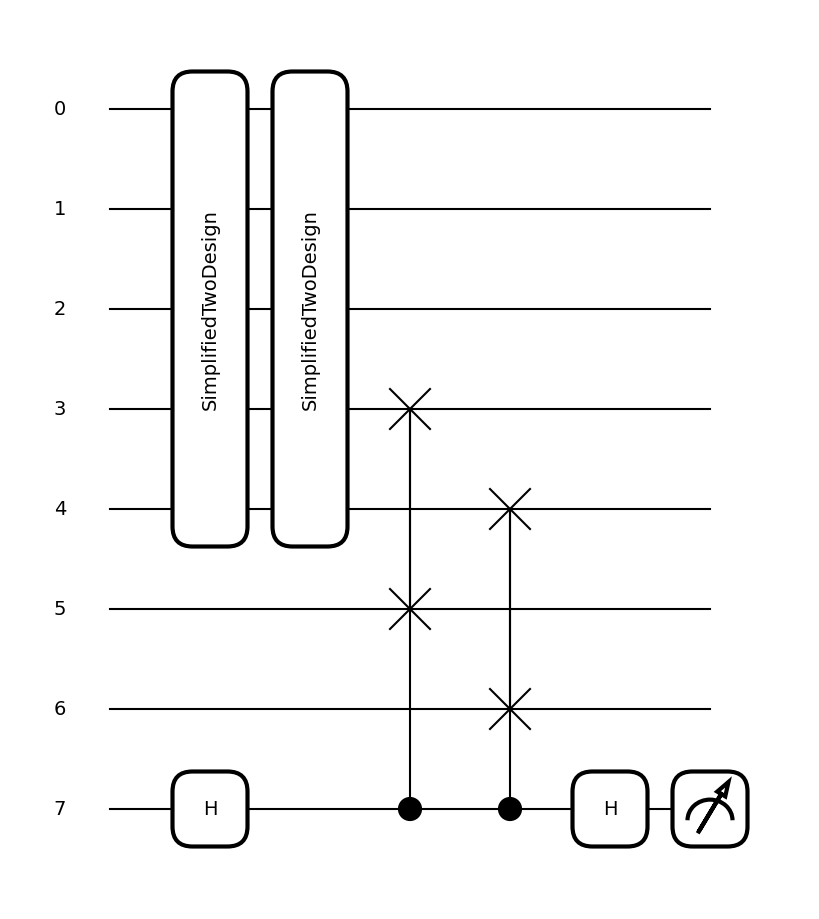

In [35]:
drawer_2 = qml.draw_mpl(digits_autoencoder)
print(drawer_2(params_digits))

In [36]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function_digits(params):
    
    # Ottiene le probabilità di misurazione
    probs = digits_autoencoder(params)
    #print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    #print(f"Probability of measuring 1: {cost}")
    return cost

In [37]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs_digits = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params_digits, cost_val = opt.step_and_cost(cost_function_digits, params_digits)
    costs_digits.append(cost_val)
    #if i%5==0:
        #print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
#print("Pesi ottimizzati:", params)
#opt_weights = params

Fit in 20.37 seconds


In [38]:
opt_weights_digits = params_digits
print(opt_weights_digits)

[ 0.72041005  1.07869746 -0.10599674  0.28452413  0.36807256  0.94276755
  0.76743516  0.15523318  0.93269252  0.31067134  0.42710779  0.77589437
  0.62242162 -0.00823104  0.5107473   0.08278701  0.74190573  0.53619672
  0.33761517  0.9429097   0.32320293  1.0880195   0.70301896  0.3636296
  1.11662401  0.6567883   0.03669251  0.49246704 -0.12402514  0.44927281
 -0.01274821  0.27941454  0.79524053  0.42074465  0.34995343  1.02784054
  0.11300478  0.38415757  0.45321584  0.95431358  0.2821888   0.44346465]


In [39]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights_digits.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])

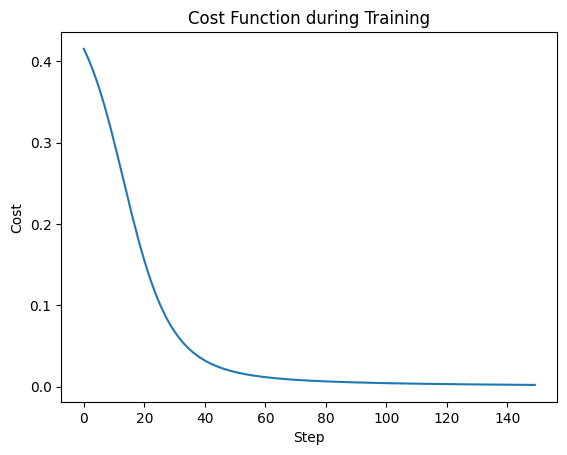

In [40]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs_digits)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [41]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)
@qml.qnode(dev_autoencoder)
def autoencoder_digits(opt_weights):
    ansatz_enc(opt_weights, n_wires_latent, n_wires_trash)
    ansatz_digits(opt_weights, n_wires_latent, n_wires_trash) 
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(ansatz_digits)(opt_weights, n_wires_latent, n_wires_trash)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    #return qml.probs(wires=[0, 1, 2, 3, 4])

(<Figure size 1000x700 with 1 Axes>, <Axes: >)


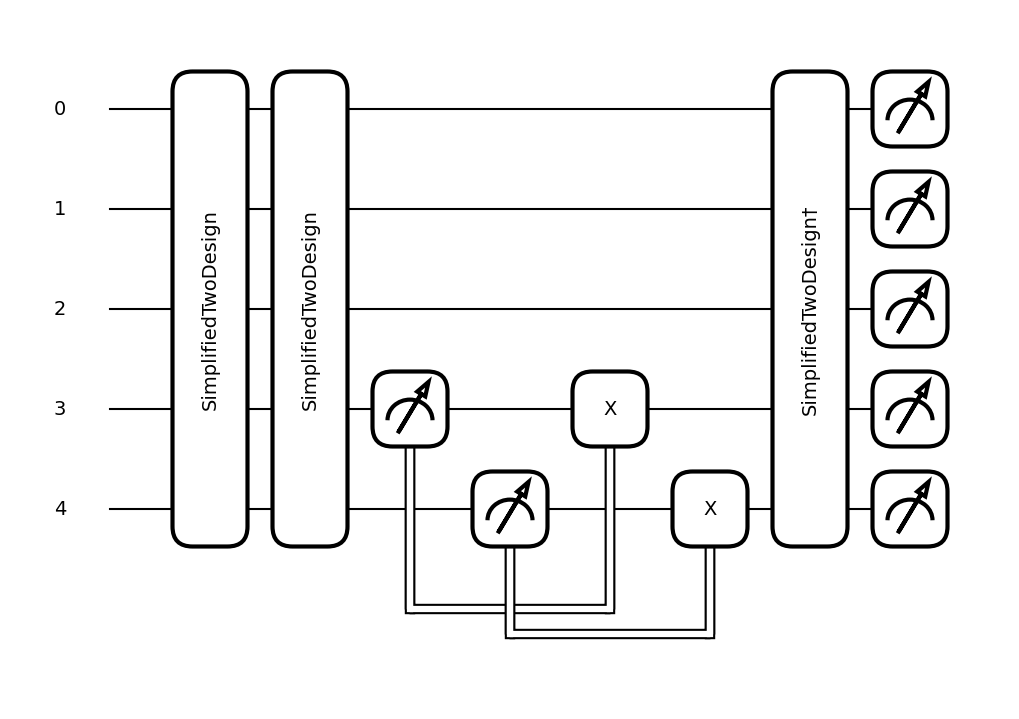

In [42]:
drawer_3 = qml.draw_mpl(autoencoder_digits)
print(drawer_3(opt_weights_digits))

In [43]:
dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev)
def test_digits(params):
    ansatz_digits(params, n_wires_latent, n_wires_trash)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

In [44]:
fidelity(test_digits(opt_weights_digits), autoencoder_digits(opt_weights_digits))

NameError: name 'fidelity' is not defined

In [ ]:
dev_autoencoder1 = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash+2)
@qml.qnode(dev_autoencoder1)
def autoencoder_digits_state(opt_weights):
    ansatz_enc(opt_weights, n_wires_latent, n_wires_trash)
    ansatz_digits(opt_weights, n_wires_latent, n_wires_trash) 
    qml.SWAP(wires=[3, 6])
    qml.SWAP(wires=[4, 5])
    qml.adjoint(ansatz_digits)(opt_weights, n_wires_latent, n_wires_trash)
    return qml.state()

(<Figure size 800x800 with 1 Axes>, <Axes: >)


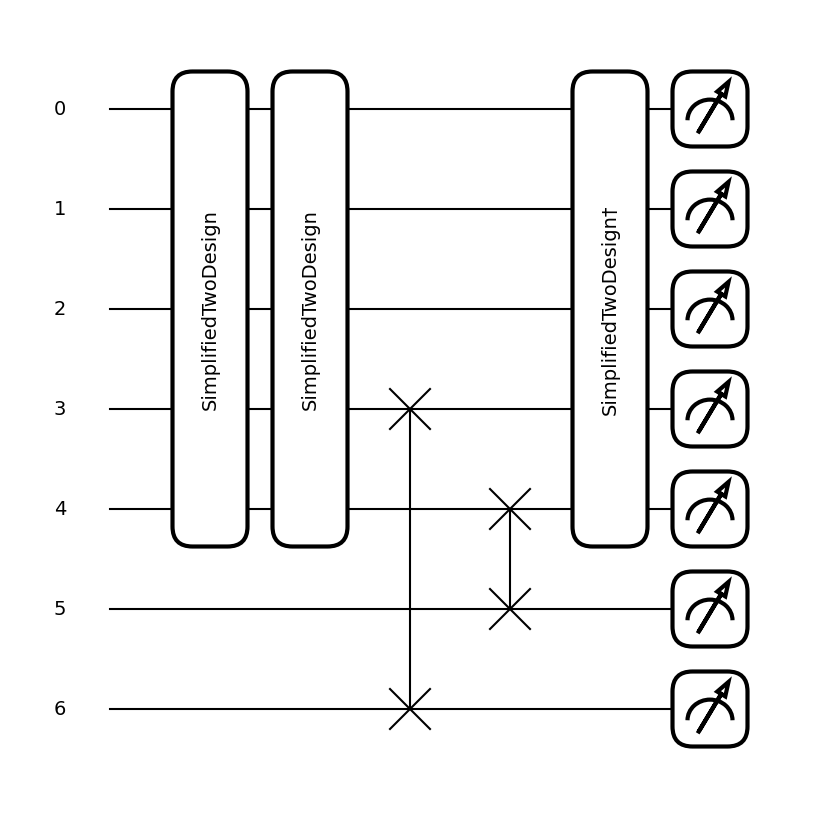

In [ ]:
drawer_4 = qml.draw_mpl(autoencoder_digits_state)
print(drawer_4(opt_weights_digits))

In [ ]:
def fid(initial_state, test_state):
    return np.sqrt(np.dot(initial_state, test_state) ** 2)

In [ ]:
dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev)
def test_digits_state(params):
    ansatz_digits(params, n_wires_latent, n_wires_trash)
    return qml.state()

In [ ]:
print(qml.math.fidelity_statevector(test_digits_state(opt_weights_digits), autoencoder_digits_state(opt_weights_digits)[:32]))

0.003693921988015116
